In [1]:
# Code based on:
# https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03

# install
!pip install pytorch-pretrained-bert pytorch-nlp

from google.colab import files
import os
import re
import pandas as pd
from io import StringIO

# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# n_gpu = torch.cuda.device_count()
# torch.cuda.get_device_name(0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 8.4 MB/s 
     |████████████████████████████████| 90 kB 3.4 MB/s 
     |████████████████████████████████| 132 kB 19.6 MB/s 
     |████████████████████████████████| 10.2 MB 5.1 MB/s 
     |████████████████████████████████| 79 kB 2.3 MB/s 
     |████████████████████████████████| 140 kB 57.1 MB/s 
     |████████████████████████████████| 127 kB 50.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
'''
Read MSH data
'''
class MSD_Load:
  def UploadMSDFiles():
    uploaded = files.upload()

  def FilePaths(ParentPath):
    Paths = []
    with os.scandir(ParentPath) as entries:
        for entry in entries:
          if entry.name.endswith('.arff'):
            Paths.append(ParentPath + entry.name)
    return Paths
  
  def ExtractDat(ParentPath):
    MSD_Load.UploadMSDFiles()

    Paths = MSD_Load.FilePaths(ParentPath)

    FinalData = ''
    CUIDic = {}
    for entry in Paths:
      match = re.search(r'/content/(.*)_pmids_tagged.arff',entry).group(1)
      with open(entry, 'r', encoding = "ISO-8859-1") as f:
        data = f.read()
        
        # Extract CUI, attributes, and data
        CUIData = re.search(r'@RELATION (.*)\n', data).group(1).split('_')
        Attributes = re.findall(r'@ATTRIBUTE (.*)\n', data)
        FullData = re.search(r'@DATA\n(.*)', data, re.DOTALL).group(1)

        # Match CUI and M#s
        Classes = [i for i in Attributes if 'class' in i]
        Index = Attributes.index(Classes[0])
        MVals = re.search(r'class {(.*)}', Classes[0])
        MValsList = MVals.group(1).split(', ')

        # Replace M#s with correct CUIs in FullData
        c = 0
        for CUI in CUIData:
          FullData = FullData.replace(MValsList[c] + '\n',CUI + '\n')
          c += 1

        # Insert ambiguous at the start of all lines
        FullData = FullData.split('\n')
        del FullData[-1]
        c = 0
        for line in FullData:
          FullData[c] = match + ',' + line
          c += 1
        FullData = '\n'.join(FullData)

        # Append to data list
        FinalData += FullData + '\n'

        CUIDic[match] = CUIData

        f.close()

    # Join data
    Attributes[Index] = 'CUI'
    AttributesStr = 'ambiguous word,' + ",".join(Attributes) + '\n'
    FinalData = AttributesStr + FinalData
    return MSD_Load.String2DF(FinalData), CUIDic

  def String2DF(String):
    # Just use splits
    String = String.split('\n')

    # Change relevant commas to tabs
    FinalString = ''
    c = 0
    for element in String:
      ElementList = element.split('"')
      if len(ElementList)-3 != 0:
        FinalString += ElementList[0].replace(',', '\t') + '\n'
      else:
        ElementList[0] = ElementList[0].replace(',', '\t')
        ElementList[2] = ElementList[2].replace(',', '\t')
        FinalString += '"'.join(ElementList) + '\n'
      c += 1

    # Convert tab seperated values to a df
    df = pd.read_csv(StringIO(FinalString), sep = '\t')
    return df

# MSD_Load.UploadMSDFiles()
# paths = MSD_Load.FilePaths('/content/')
[df, CUIDic] = MSD_Load.ExtractDat('/content/')
# df = MSD_Load.String2DF(Data)

Saving AA_pmids_tagged.arff to AA_pmids_tagged.arff
Saving ADA_pmids_tagged.arff to ADA_pmids_tagged.arff
Saving ADH_pmids_tagged.arff to ADH_pmids_tagged.arff
Saving ADP_pmids_tagged.arff to ADP_pmids_tagged.arff
Saving Adrenal_pmids_tagged.arff to Adrenal_pmids_tagged.arff
Saving Ala_pmids_tagged.arff to Ala_pmids_tagged.arff
Saving ALS_pmids_tagged.arff to ALS_pmids_tagged.arff
Saving ANA_pmids_tagged.arff to ANA_pmids_tagged.arff
Saving Arteriovenous Anastomoses_pmids_tagged.arff to Arteriovenous Anastomoses_pmids_tagged.arff
Saving Astragalus_pmids_tagged.arff to Astragalus_pmids_tagged.arff
Saving BAT_pmids_tagged.arff to BAT_pmids_tagged.arff
Saving B-Cell Leukemia_pmids_tagged.arff to B-Cell Leukemia_pmids_tagged.arff
Saving benchmark_mesh.txt to benchmark_mesh.txt
Saving BLM_pmids_tagged.arff to BLM_pmids_tagged.arff
Saving Borrelia_pmids_tagged.arff to Borrelia_pmids_tagged.arff
Saving BPD_pmids_tagged.arff to BPD_pmids_tagged.arff
Saving BR_pmids_tagged.arff to BR_pmids_tagg

In [3]:
# Examples of the Raw Data

df.head()

,ambiguous word,PMID integer,citation string,CUI
0,BR,20066953,Mass mortality associated with a frog virus 3-...,C0006137
1,BR,19936460,Vaccination against the influenza virus and mo...,C0006137
2,BR,19848087,Molecular characterization of Brazilian infect...,C0006137
3,BR,19820814,Portuguese-language version of the Epworth sle...,C0006137
4,BR,19750383,[Predictors of subjective burden for families ...,C0006137


In [4]:
class Data_Processing:
  def Windowed(CitationString,Number=50):
    POS = CitationString.index('<e>')+1
    Size = len(CitationString)
    Bottom = POS-Number
    Top = POS+Number+1

    # Pos Check
    if Bottom < 0:
      Bottom = 0
    if Top > Size:
      Top = Size

    # Size Check
    Ideal = Number*2 + 1
    if Size<Ideal:
        Ideal = Size
    Current = Top - Bottom
    Difference = Ideal - Current
    if Difference != 0:
      if Top == Size:
        Bottom -= 2
      else:
        Top += 1

    return CitationString[Bottom:Top]

  def BasicProc(df):
    Corpus = []
    TrueLabels = []
    for index, row in df.iterrows():
      Corpus.append(Data_Processing.Windowed(row['citation string']))
      TrueLabels.append(row['CUI'])

    return Corpus, TrueLabels

  def FakeLabels(df, CUIDic):
    Corpus = []
    FakeLabels = []
    for index, row in df.iterrows():
      TempLabels = CUIDic[row['ambiguous word']]
      FakeLabels = FakeLabels + TempLabels
      Corpus.append(Data_Processing.Windowed(row['citation string'])*len(TempLabels))

    return Corpus, FakeLabels

  def DataMerge(TrueCorpus, TrueLabels, FalseCorpus, FalseLabels):
    CombinedCorpus = []
    BoolLabels = []

    # True pairs
    BoolLabels += [True]*len(TrueCorpus)
    for i in range(len(TrueCorpus)):
      CombinedCorpus.append('[CLS] ' + TrueCorpus[i] + ' [SEP] ' + TrueLabels[i] + ' [SEP]')

    # False pairs
    BoolLabels += [False]*len(FalseCorpus)
    for i in range(len(FalseCorpus)):
      CombinedCorpus.append('[CLS] ' + FalseCorpus[i] + ' [SEP] ' + FalseLabels[i] + ' [SEP]')

    return CombinedCorpus, BoolLabels

  def ApBertTokenizer(Corpus):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

    BertCorpus = []
    C = 0
    for element in Corpus:
      BertCorpus.append(tokenizer.tokenize(element))
      C += 1
      if C % 1000 == 0:
        print(f'{C} / ', len(Corpus))

    return BertCorpus

  def main(df, CUIDic):
    TrueCorpus, TrueLabels = Data_Processing.BasicProc(df)
    FalseCorpus, FalseLables = Data_Processing.FakeLabels(df,CUIDic)

    RawCorpus, Lables = Data_Processing.DataMerge(TrueCorpus, TrueLabels, FalseCorpus, FalseLables)
    Corpus = Data_Processing.ApBertTokenizer(RawCorpus)

    return Corpus, Lables

Corpus, Lables = Data_Processing.main(df, CUIDic)

100%|██████████| 231508/231508 [00:00<00:00, 1250122.22B/s]


1000 /  75776
2000 /  75776
3000 /  75776
4000 /  75776
5000 /  75776
6000 /  75776
7000 /  75776
8000 /  75776
9000 /  75776
10000 /  75776
11000 /  75776
12000 /  75776
13000 /  75776
14000 /  75776
15000 /  75776
16000 /  75776
17000 /  75776
18000 /  75776
19000 /  75776
20000 /  75776
21000 /  75776
22000 /  75776
23000 /  75776
24000 /  75776
25000 /  75776
26000 /  75776
27000 /  75776
28000 /  75776
29000 /  75776
30000 /  75776
31000 /  75776
32000 /  75776
33000 /  75776
34000 /  75776
35000 /  75776
36000 /  75776
37000 /  75776
38000 /  75776
39000 /  75776
40000 /  75776
41000 /  75776
42000 /  75776
43000 /  75776
44000 /  75776
45000 /  75776
46000 /  75776
47000 /  75776
48000 /  75776
49000 /  75776
50000 /  75776
51000 /  75776
52000 /  75776
53000 /  75776
54000 /  75776
55000 /  75776
56000 /  75776
57000 /  75776
58000 /  75776
59000 /  75776
60000 /  75776
61000 /  75776
62000 /  75776
63000 /  75776
64000 /  75776
65000 /  75776
66000 /  75776
67000 /  75776
6800

In [5]:
# Prepare input tokens
class BertToken:
  def FindMaxList(Corpus):
    list_len = [len(i) for i in Corpus]
    return max(list_len)
  
  def main(Corpus):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

    MAX_LEN = BertToken.FindMaxList(Corpus)
    input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in Corpus],
                              maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in Corpus]
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    return input_ids

input_ids = BertToken.main(Corpus)

In [6]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [7]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, Lables, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
                                             
# # Convert all of our data into torch tensors, the required datatype for our model
# train_inputs = torch.tensor(train_inputs)
# validation_inputs = torch.tensor(validation_inputs)
# train_labels = torch.tensor(train_labels)
# validation_labels = torch.tensor(validation_labels)
# train_masks = torch.tensor(train_masks)
# validation_masks = torch.tensor(validation_masks)

# # Select a batch size for training. 
# batch_size = 32

# # Create an iterator of our data with torch DataLoader 
# train_data = TensorDataset(train_inputs, train_masks, train_labels)
# train_sampler = RandomSampler(train_data)
# train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
# validation_sampler = SequentialSampler(validation_data)
# validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

Epoch 1/3
480/480 [==============================] - 501s 1s/step - loss: 0.0000e+00 - accuracy: 1.6292e-05 - val_loss: 0.0000e+00 - val_accuracy: 1.4663e-04
Epoch 2/3
480/480 [==============================] - 500s 1s/step - loss: 0.0000e+00 - accuracy: 1.6292e-05 - val_loss: 0.0000e+00 - val_accuracy: 1.4663e-04
Epoch 3/3
480/480 [==============================] - 500s 1s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 1.4663e-04


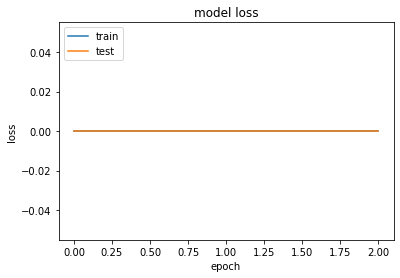

In [8]:
'''
1-layer LSTM
'''

import numpy as np
import keras
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers.core import Dense, Activation
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

# train_inputs, validation_inputs, train_labels, validation_labels
TrainData = []
for list in train_inputs:
  BlankList = []
  for element in list:
    BlankList.append([element])
  TrainData.append(BlankList)

TrainLabels = []
for element in train_labels:
  TrainLabels.append([element])

ConvertedCorpus = TrainData
ConvertedLabels = TrainLabels

ConvertedCorpus = np.array(ConvertedCorpus)# .reshape((1,WindowSize,len(ConvertedCorpus)))
ConvertedLabels = np.array(ConvertedLabels)

import tensorflow as tf

ConvertedCorpus = tf.cast(ConvertedCorpus, tf.float32)
ConvertedLabels = tf.cast(ConvertedLabels, tf.float32)

model = keras.Sequential(
    [
        keras.Input(shape=(283, 1)),
        keras.layers.LSTM(128),
        # Bidirectional(LSTM(128)),
        keras.layers.Dense(1,activation="softmax"),
        # Dropout(.2, input_shape=(2,)),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.000001)
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=[tf.keras.metrics.Accuracy()]) #, metrics=['acc'])

history = model.fit(x=ConvertedCorpus, y=ConvertedLabels, validation_split=0.1, batch_size=128, epochs=3, shuffle=True).history

model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

Epoch 1/3
480/480 [==============================] - 718s 1s/step - loss: 0.0000e+00 - accuracy: 1.6292e-05 - val_loss: 0.0000e+00 - val_accuracy: 1.4663e-04
Epoch 2/3
480/480 [==============================] - 682s 1s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 1.4663e-04
Epoch 3/3
480/480 [==============================] - 695s 1s/step - loss: 0.0000e+00 - accuracy: 1.6292e-05 - val_loss: 0.0000e+00 - val_accuracy: 1.4663e-04


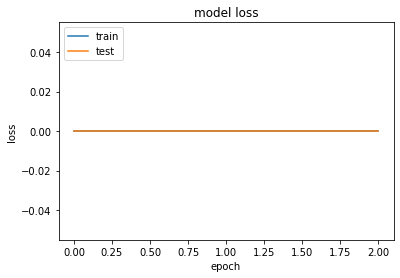

In [9]:
'''
1-layer BiLSTM
'''

model = keras.Sequential(
    [
        keras.Input(shape=(283, 1)),
        # keras.layers.LSTM(128),
        Bidirectional(LSTM(128)),
        keras.layers.Dense(1,activation="softmax"),
        # Dropout(.2, input_shape=(2,)),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.000001)
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=[tf.keras.metrics.Accuracy()]) #, metrics=['acc'])

history = model.fit(x=ConvertedCorpus, y=ConvertedLabels, validation_split=0.1, batch_size=128, epochs=3, shuffle=True).history

model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [10]:
!pip install transformers

import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

# train_inputs, validation_inputs, train_labels, validation_labels
TrainData = []
for list in train_inputs:
  BlankList = []
  for element in list:
    BlankList.append([element])
  TrainData.append(BlankList)

TrainLabels = []
for element in train_labels:
  TrainLabels.append([element])

ConvertedCorpus = TrainData
ConvertedLabels = TrainLabels

ConvertedCorpus = np.array(ConvertedCorpus)# .reshape((1,WindowSize,len(ConvertedCorpus)))
ConvertedLabels = np.array(ConvertedLabels)

import tensorflow as tf

ConvertedCorpus = tf.cast(ConvertedCorpus, tf.float32)
ConvertedLabels = tf.cast(ConvertedLabels, tf.float32)

bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels =2)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('Accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer, metrics = [metric])

# TrainData
# ConvertedLabels = TrainLabels

history = bert_model.fit(x=ConvertedCorpus, y=ConvertedLabels,validation_split=0.1, batch_size=16, epochs=4, shuffle=True).history

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 7.3 MB/s 
     |████████████████████████████████| 7.6 MB 51.1 MB/s 
     |████████████████████████████████| 182 kB 68.2 MB/s 


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4


ValueError: ignored